# Titanic - Machine Learning from Disaster
   **⸺ The legendary Titanic ML competition in Kaggle**

![Titanic](https://cdn.activestate.com/wp-content/uploads/2021/05/kaggle-titanic-challenge.jpg)

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew. While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, it is asked to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data. The dataset is available in [1].

Simply, use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

In [1]:
#Initialization of python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from pandas import Series, DataFrame
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
np.random.seed(500)
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
#Read dataset
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

In [3]:
#Look into dataset properties
train.info(); test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

Died        549
Survived    342
Name: Survived, dtype: int64 

      Sex  Survived
0  female  0.742038
1    male  0.188908


   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


Text(0.5, 1.0, 'Survival considering Ticket Class')

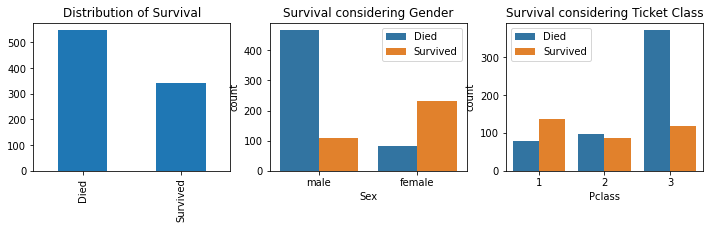

In [4]:
#Data Visualization respect to Survival rate

#Distribution of Survival
fig = plt.figure(figsize=(12,6)) 
plt.subplot2grid((2,3),(0,0))
SV= train.Survived.value_counts()
SV.index = ['Died','Survived']
SV.plot(kind='bar'); plt.title("Distribution of Survival") 
print(SV, '\n')

#Distribution of Survival considering Gender
plt.subplot2grid((2,3),(0,1))
sns.countplot(x='Sex', hue='Survived', data=train)
print(train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())
plt.legend(('Died', 'Survived')); plt.title("Survival considering Gender") 

#Distribution of Survival considering Ticket Class
print('\n')
plt.subplot2grid((2,3),(0,2))
sns.countplot(x='Pclass', hue='Survived', data=train)
print(train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())
plt.legend(('Died', 'Survived')); plt.title("Survival considering Ticket Class") 

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


Text(0.5, 1.0, 'Survival considering Port of Embarkation')

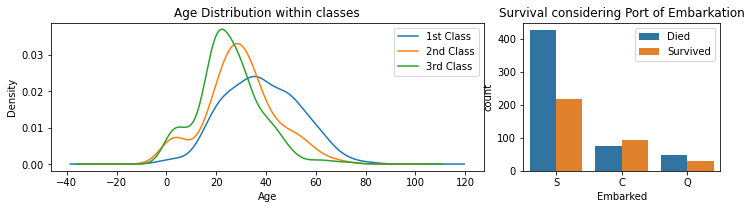

In [5]:
#Age Distribution within classes
fig = plt.figure(figsize=(12,6)) 
plt.subplot2grid((2,3),(0,0), colspan=2)
train.Age[train.Pclass == 1].plot(kind='kde')    
train.Age[train.Pclass == 2].plot(kind='kde')
train.Age[train.Pclass == 3].plot(kind='kde')
plt.title("Age Distribution within classes"); plt.xlabel("Age"); plt.legend(('1st Class', '2nd Class','3rd Class')) 

#Distribution of Survival considering Port of Embarkation
plt.subplot2grid((2,3),(0,2))
sns.countplot(x='Embarked', hue='Survived', data=train)
print(train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())
plt.legend(('Died', 'Survived')); plt.title("Survival considering Port of Embarkation") 

In [6]:
#Delete insignificant data from the dataset
Arrange_train = train.drop(['PassengerId','Name','Ticket','Cabin','Survived'], axis=1)
Arrange_test = test.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)

In [7]:
#Care of Missing Values
Arrange_train['Age'].fillna(Arrange_train['Age'].median(), inplace=True)
Arrange_train['Embarked'].fillna(Arrange_train['Embarked'].mode()[0], inplace=True)
Arrange_test['Age'].fillna(Arrange_test['Age'].median(), inplace=True)
Arrange_test['Fare'].fillna(Arrange_test['Fare'].median(), inplace=True)

In [8]:
#changing Categorical(Sex, Embarked) into numerical
#Train data
SetSexTR = Arrange_train['Sex'].copy().values
SetSexTR[SetSexTR == 'male'] = 0 
SetSexTR[SetSexTR == 'female'] = 1 
SetEmbTR = Arrange_train['Embarked'].copy().values
SetEmbTR[SetEmbTR =='S'] = 0 
SetEmbTR[SetEmbTR =='C'] = 1
SetEmbTR[SetEmbTR =='Q'] = 2
#Test data
SetSex = Arrange_test['Sex'].copy().values
SetSex[SetSex == 'male'] = 0  
SetSex[SetSex == 'female'] = 1 
SetEmb = Arrange_test['Embarked'].copy().values
SetEmb[SetEmb =='S'] = 0 
SetEmb[SetEmb =='C'] = 1
SetEmb[SetEmb =='Q'] = 2

In [9]:
#assigning the numeric values to columns that held string values
#Train data
X_train = Arrange_train.copy()
X_train.loc[:,'Sex'] = SetSexTR 
X_train.loc[:,'Embarked'] = SetEmbTR
Y_train = train['Survived'].astype(int)
#Test data
X_test = Arrange_test.copy()
X_test.loc[:,'Sex'] = SetSex 
X_test.loc[:,'Embarked'] = SetEmb

In [10]:
#Standardize the features 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Apply Principal Component Analysis (PCA) 
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

In [11]:
#Hyperparemeter tunung of Classifire with GridSearchCV
model = RandomForestClassifier()
n_estimators = [10, 50, 100]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
k= KFold(n_splits=5, random_state=100)
grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=k,n_jobs=4, scoring='accuracy',error_score=0, verbose=1)
grid_result = grid_search.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print(grid_result.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    4.2s finished


Best: 0.762080 using {'max_features': 'log2', 'n_estimators': 100}
RandomForestClassifier(max_features='log2')


In [12]:
#Hyperparemeter tunung of Classifire with RandomizedSearchCV
model = RandomForestClassifier()
n_iter_search = 200
k= KFold(n_splits=10, random_state=100)
rand_param = {
    'n_estimators': [10, 50, 100],
    'max_features': ['sqrt', 'log2']
 }
Rf_search = RandomizedSearchCV(model, param_distributions=rand_param, n_iter=n_iter_search, cv=k, n_jobs=-1, verbose=1)
Rf_result = Rf_search.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (Rf_result.best_score_, Rf_result.best_params_))
print(Rf_result.best_estimator_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 6 is smaller than n_iter=200. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.8s finished


Best: 0.763296 using {'n_estimators': 100, 'max_features': 'sqrt'}
RandomForestClassifier(max_features='sqrt')


In [13]:
#Perform training using optimal model(having tuned hyperparemeter) with cross validation
model = RandomForestClassifier(max_features='sqrt', n_estimators=50)
score = cross_val_score(model, X_train, Y_train, cv=10, n_jobs=4)
model.fit(X_train, Y_train)
print("Cross-validation accuracy: {0:.4f}".format(score.mean()))

#Perform Prediction on test data
y_pred = model.predict(X_test)

Cross-validation accuracy: 0.7644


***For more exciting notebooks visit my Kaggle workspace!***  [ https://www.kaggle.com/pankajbhowmik ]